# LSTM (TA Feature)

- Model : LSTM

- Data : KOSDAQ 2018.01.02 ~ 2024.04.30 / 2020년 1월 2일 기준 시총 100억~ 200억

- Imbalanced Data : Down sampling

- Feature : '시가', '고가', '저가', '종가', '거래량', 'RSI', 'MACD', 'MACD_Signal',
                  'Stochastic_Oscillator', 'Bollinger_Up', 'Bollinger_Down', 'VWAP',
                  'SMA_5', 'SMA_20', 'SMA_60', 'SMA_120'

- Scaler : Standard

- sequences 수정 :
시퀀스 데이터가 하루 단위로 생성되어 비슷한 값들로 과적합 되는 문제 방지

    **기존**<br/>
    2020년 1월 2일부터 1월 2일 + sequence_length까지,<br/>
    2020년 1월 3일부터 1월 3일 + sequence_length까지,<br/>
    <br/>
    **수정** <br/>
    1월 2일부터 1월 2일 + sequence_length까지<br/>
    1월 2일 + look_forward부터 + sequence_length까지

- Test : 

    시총 100억 ~ 200억<br/>
    Train(2018~2020), val(2021~2022), test(2023~2024)

    train과 val에만 down sampling 적용, test는 Imbalanced Data 사용

    시총 200억 ~ 300억 데이터
    Imbalanced Data 사용


## Data Processing

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from datetime import datetime
from sklearn.utils import resample
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt

In [45]:
import pandas as pd
from datetime import datetime
from pykrx import stock
import os

# Initialize the current datetime
now = datetime.now()

# Define your date range
today_date1 = '20240430'
start_date = '20180102'

# Define the market list
market_list = ['KOSDAQ']

# Initialize a list to collect all ticker information
ticker_info_list = []

# Collect all ticker information
for market_nm in market_list:
    try:
        ticker_list = stock.get_market_ticker_list(today_date1, market=market_nm)
        for ticker in ticker_list:
            corp_name = stock.get_market_ticker_name(ticker)
            ticker_info_list.append({
                'ticker': ticker,
                'corp_name': corp_name,
                'market': market_nm
            })
    except Exception as e:
        print(f"Failed to process market {market_nm}: {str(e)}")

# Convert collected ticker information into a DataFrame
kor_ticker_list_df = pd.DataFrame(ticker_info_list)

# Initialize a list to collect OHLCV data
all_ohlcv_list = []

# Retrieve and collect OHLCV data for each ticker
for ticker in kor_ticker_list_df['ticker']:
    try:
        df_raw = stock.get_market_ohlcv(start_date, today_date1, ticker)
        df_raw.reset_index(inplace=True)
        df_raw['ticker'] = ticker
        all_ohlcv_list.append(df_raw)
        print(f'{ticker} success')
    except Exception as e:
        print(f'{ticker} fail - {str(e)}')

# Concatenate all collected OHLCV data into a single DataFrame
all_ohlcv = pd.concat(all_ohlcv_list, ignore_index=True)

# Define the directory to save the data
save_dir = '/Users/yangdong-yeong/Desktop/Fnguide/data/'

# Create the directory if it does not exist
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Save the combined data to a CSV file
all_ohlcv.to_csv(f'{save_dir}/KOSDAQ(2018~2024).csv', index=False)
print('All data saved successfully.')


060310 success
054620 success
265520 success
211270 success
109960 success
139050 success
126600 success
013720 success
083790 success
035760 success
311690 success
051500 success
058820 success
023460 success
056730 success
065770 success
083660 success
456440 success
060900 success
290120 success
025440 success
068790 success
241520 success
180400 success
245620 success
037370 success
050120 success
214270 success
130500 success
900290 success
083450 success
297890 success
440290 success
078150 success
195940 success
028300 success
278650 success
067630 success
024850 success
047920 success
115450 success
046210 success
403870 success
036640 success
439730 success
442770 success
448760 success
467930 success
469480 success
095340 success
099520 success
950170 success
067290 success
035900 success
318000 success
024840 success
024120 success
455250 success
458320 success
464680 success
021320 success
036670 success
044180 success
046440 success
035600 success
226360 success
111870 suc

In [51]:
# 파일 경로
file_path = '/Users/yangdong-yeong/Desktop/Fnguide/data/KOSDAQ(2018~2024).csv'

# CSV 파일 불러오기

df = pd.read_csv(file_path)

# 'ticker' 열의 값을 문자열로 변환하고, 5자리인 경우 앞에 '0'을 추가
df['ticker'] = df['ticker'].astype(str).str.zfill(6)

/var/folders/h0/rz02629x2b535_x0qf1h70zm0000gn/T/ipykernel_37678/1711920004.py:6: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path)


In [52]:
# 시가총액 데이터 가져오기
market_cap_df = stock.get_market_cap("20180102")  # 2020년 1월 1일 데이터

# 100억 이상 200억 이하인 종목 필터링
market_cap_df = market_cap_df[(market_cap_df['시가총액'] >= 10000000000) & (market_cap_df['시가총액'] <= 20000000000)]

# 원본 데이터셋 (예를 들어 'df')에서 시가총액 100억 이상 200억 이하인 종목만 추출
filtered_tickers = market_cap_df.index
df = df[df['ticker'].isin(filtered_tickers)]

In [53]:
#날짜 포맷 확인 및 변환
df['날짜'] = pd.to_datetime(df['날짜'])

# ticker 별로 데이터 분할
tickers = tickers = df['ticker'].unique()
ticker_df = {ticker: df[df['ticker'] == ticker] for ticker in tickers}

# 스케일링
scalers = {ticker: StandardScaler() for ticker in tickers}

for ticker in tickers:
    df_copy = ticker_df[ticker].copy()
    df_copy[['시가', '고가', '저가', '종가', '거래량']] = df_copy[['시가', '고가', '저가', '종가', '거래량']].astype(float)
    
    # 데이터 스케일링
    scaled_data = scalers[ticker].fit_transform(df_copy[['시가', '고가', '저가', '종가', '거래량']])
    
    # 스케일된 데이터를 DataFrame으로 만들고, 원본과 같은 데이터 형식(int)으로 캐스팅합니다.
    scaled_df = pd.DataFrame(scaled_data, columns=['시가', '고가', '저가', '종가', '거래량'], index=df_copy.index)
    for col in ['시가', '고가', '저가', '종가', '거래량']:
        # 원본 데이터의 데이터 타입에 맞춰 캐스팅합니다.
        scaled_df[col] = scaled_df[col].astype(ticker_df[ticker][col].dtype)

    # 스케일된 데이터를 원본 DataFrame에 적용
    ticker_df[ticker].loc[:, ['시가', '고가', '저가', '종가', '거래량']] = scaled_df

# 메모리 문제로 파일 중간 저장
all_data = pd.concat([ticker_df[ticker] for ticker in tickers], axis=0, ignore_index=True)
all_data.to_csv('/Users/yangdong-yeong/Desktop/Fnguide/data/KOSDAQ(2018~2024)_100억~200억_scaled.csv', index=False)

In [3]:
# 기술적 지표 정의
def compute_RSI(data, window=14):
    diff = data.diff(1).dropna()
    gain = 0 * diff
    loss = 0 * diff
    gain[diff > 0] = diff[diff > 0]
    loss[diff < 0] = -diff[diff < 0]
    avg_gain = gain.rolling(window=window).mean()
    avg_loss = loss.rolling(window=window).mean()
    avg_loss += 1e-10  # Adjust to prevent division by zero leading to Inf
    rs = avg_gain / (avg_loss)
    rsi = 100 - (100 / (1 + rs))
    return rsi


def compute_MACD(data, span1=12, span2=26, signal_span=9):
    exp1 = data.ewm(span=span1, adjust=False).mean()
    exp2 = data.ewm(span=span2, adjust=False).mean()
    macd = exp1 - exp2
    signal = macd.ewm(span=signal_span, adjust=False).mean()
    return macd, signal

def compute_Stochastic_Oscillator(data, window=14):
    l14 = data['저가'].rolling(window=window).min()
    h14 = data['고가'].rolling(window=window).max()
    # Ensure no division by zero
    k = 100 * ((data['종가'] - l14) / (h14 - l14 + 1e-10))
    return k


def compute_Bollinger_Bands(data, window=20):
    sma = data.rolling(window=window).mean()
    std = data.rolling(window=window).std()
    bollinger_up = sma + std * 2
    bollinger_down = sma - std * 2
    return bollinger_up, bollinger_down

def compute_VWAP(df):
    vwap = (df['거래량'] * (df['고가'] + df['저가'] + df['종가']) / 3).cumsum() / df['거래량'].cumsum()
    return vwap

def compute_SMA(data, windows):
    smas = {}
    for window in windows:
        smas[f'SMA_{window}'] = data.rolling(window=window).mean()
    return smas

In [5]:
# CSV 파일 불러오기
file_path = '/Users/yangdong-yeong/Desktop/Fnguide/data/KOSDAQ(2018~2024)_100억~200억_scaled.csv'
ticker_df = pd.read_csv(file_path)

# '날짜' 열을 datetime 객체로 변환
ticker_df['날짜'] = pd.to_datetime(ticker_df['날짜'])

# ticker 별로 데이터 분할
tickers = ticker_df['ticker'].unique()
ticker_data = {ticker: ticker_df[ticker_df['ticker'] == ticker] for ticker in tickers}

# 기술적 지표 추가
for ticker in tickers:
    data = ticker_data[ticker].copy(deep=True)
    
    # Compute and assign new columns
    data.loc[:, 'RSI'] = compute_RSI(data['종가'])
    macd, macd_signal = compute_MACD(data['종가'])
    data.loc[:, 'MACD'] = macd
    data.loc[:, 'MACD_Signal'] = macd_signal
    data.loc[:, 'Stochastic_Oscillator'] = compute_Stochastic_Oscillator(data)
    bollinger_up, bollinger_down = compute_Bollinger_Bands(data['종가'])
    data.loc[:, 'Bollinger_Up'] = bollinger_up
    data.loc[:, 'Bollinger_Down'] = bollinger_down
    data.loc[:, 'VWAP'] = compute_VWAP(data)
    
    sma_values = compute_SMA(data['종가'], [5, 20, 60, 120])
    for sma_key, sma_value in sma_values.items():
        data.loc[:, sma_key] = sma_value
    
    data.bfill(inplace=True)
    data.ffill(inplace=True)
    
    ticker_data[ticker] = data

feature_columns = ['시가', '고가', '저가', '종가', '거래량', 'RSI', 'MACD', 'MACD_Signal',
                  'Stochastic_Oscillator', 'Bollinger_Up', 'Bollinger_Down', 'VWAP',
                  'SMA_5', 'SMA_20', 'SMA_60', 'SMA_120']

def create_sequences_and_labels(df, sequence_length, threshold=20, look_forward=20):
    sequences = []
    labels = []
    dates = []
    for i in range(0, len(df) - sequence_length - look_forward + 1, look_forward):
        sequence_start = i
        sequence_end = i + sequence_length
        future_start = sequence_end
        future_end = future_start + look_forward
        
        sequence = df[feature_columns].iloc[sequence_start:sequence_end].values
        future_data = df['등락률'].iloc[future_start:future_end]
        
        sequences.append(sequence)
        labels.append(any(future_data >= threshold))
        dates.append(df['날짜'].iloc[sequence_start])
        
    return np.array(sequences), np.array(labels).astype(int), np.array(dates)

# Process the entire dataset into sequences
sequence_length = 120
num_features = len(feature_columns)

all_sequences = []
all_labels = []
all_dates = []

for ticker, df in ticker_data.items():
    seqs, labs, dts = create_sequences_and_labels(df, sequence_length)
    if seqs.size > 0:
        all_sequences.append(seqs)
        all_labels.append(labs)
        all_dates.append(dts)

if all_sequences:
    all_sequences = np.concatenate(all_sequences)
    all_labels = np.concatenate(all_labels)
    all_dates = np.concatenate(all_dates)
else:
    all_sequences, all_labels, all_dates = np.array([]), np.array([]), np.array([])

# Define the date ranges
train_start, train_end = datetime(2018, 1, 2), datetime(2020, 12, 31)
val_start, val_end = datetime(2021, 1, 1), datetime(2022, 12, 31)
test_start, test_end = datetime(2023, 1, 1), datetime(2024, 4, 30)

# Indices for splitting
train_indices = (all_dates >= train_start) & (all_dates <= train_end)
val_indices = (all_dates >= val_start) & (all_dates <= val_end)
test_indices = (all_dates >= test_start) & (all_dates <= test_end)

X_train, y_train = all_sequences[train_indices], all_labels[train_indices]
X_val, y_val = all_sequences[val_indices], all_labels[val_indices]
X_test, y_test = all_sequences[test_indices], all_labels[test_indices]

# Downsample the data
def downsample_data(X, y):
    # Separate majority and minority classes
    majority_indices = np.where(y == 0)[0]
    minority_indices = np.where(y == 1)[0]
    
    # Downsample majority class indices
    majority_downsampled_indices = resample(majority_indices,
                                            replace=False,
                                            n_samples=len(minority_indices),
                                            random_state=42)
    
    # Combine majority downsampled with minority indices
    downsampled_indices = np.concatenate([majority_downsampled_indices, minority_indices])
    
    # Shuffle the indices
    np.random.shuffle(downsampled_indices)
    
    return X[downsampled_indices], y[downsampled_indices]

# Apply downsampling to training and validation data
X_train, y_train = downsample_data(X_train, y_train)
X_val, y_val = downsample_data(X_val, y_val)

# Print the shapes of the datasets
print(f"Train Data Shape: X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Validation Data Shape: X_val: {X_val.shape}, y_val: {y_val.shape}")
print(f"Test Data Shape: X_test: {X_test.shape}, y_test: {y_test.shape}")

Train Data Shape: X_train: (82, 120, 16), y_train: (82,)
Validation Data Shape: X_val: (84, 120, 16), y_val: (84,)
Test Data Shape: X_test: (234, 120, 16), y_test: (234,)


In [67]:

# Print the overall date range in the dataset
print("Overall date range in the dataset:")
print(f"Min date: {ticker_df['날짜'].min()}")
print(f"Max date: {ticker_df['날짜'].max()}")

Overall date range in the dataset:
Min date: 2018-01-02 00:00:00
Max date: 2024-04-30 00:00:00


## Modeling

In [78]:
# 체크포인트를 저장할 경로 설정
checkpoint_path = '/Users/yangdong-yeong/Desktop/Fnguide/Check_Point/model_100~200_TA_Downsample_2차_scaled{epoch:02d}-{val_loss:.2f}.h5'

# F1 Score 콜백 정의
class F1ScoreCallback(Callback):
    def __init__(self, X_train, y_train, X_val, y_val, X_test, y_test):
        super().__init__()
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.X_test = X_test
        self.y_test = y_test
        
        self.train_f1_scores = []
        self.val_f1_scores = []
        self.test_f1_scores = []
        
        self.train_precision_scores = []
        self.val_precision_scores = []
        self.test_precision_scores = []
        
        self.train_recall_scores = []
        self.val_recall_scores = []
        self.test_recall_scores = []
        
    def on_epoch_end(self, epoch, logs=None):
        # Predictions and metrics for training data
        train_predict = (self.model.predict(self.X_train) > 0.5).astype(int)
        train_precision = precision_score(self.y_train, train_predict, zero_division=0)
        train_recall = recall_score(self.y_train, train_predict, zero_division=0)
        train_f1 = f1_score(self.y_train, train_predict, zero_division=0)
        
        # Predictions and metrics for validation data
        val_predict = (self.model.predict(self.X_val) > 0.5).astype(int)
        val_precision = precision_score(self.y_val, val_predict, zero_division=0)
        val_recall = recall_score(self.y_val, val_predict, zero_division=0)
        val_f1 = f1_score(self.y_val, val_predict, zero_division=0)
        
        # Predictions and metrics for testing data
        test_predict = (self.model.predict(self.X_test) > 0.5).astype(int)
        test_precision = precision_score(self.y_test, test_predict, zero_division=0)
        test_recall = recall_score(self.y_test, test_predict, zero_division=0)
        test_f1 = f1_score(self.y_test, test_predict, zero_division=0)
        
        # Append metrics to lists
        self.train_precision_scores.append(train_precision)
        self.train_recall_scores.append(train_recall)
        self.train_f1_scores.append(train_f1)
        
        self.val_precision_scores.append(val_precision)
        self.val_recall_scores.append(val_recall)
        self.val_f1_scores.append(val_f1)
        
        self.test_precision_scores.append(test_precision)
        self.test_recall_scores.append(test_recall)
        self.test_f1_scores.append(test_f1)
    
    def plot_metrics(self):
        epochs = range(1, len(self.train_f1_scores) + 1)
        
        # Plot Precision, Recall, and F1 Score for Training, Validation, and Testing
        plt.figure(figsize=(18, 6))
        
        # Plot F1 Scores
        plt.subplot(1, 3, 1)
        plt.plot(epochs, self.train_f1_scores, 'go-', label='Train F1 Score')
        plt.plot(epochs, self.val_f1_scores, 'ro-', label='Validation F1 Score')
        plt.plot(epochs, self.test_f1_scores, 'bo-', label='Test F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('F1 Score')
        plt.title('F1 Score Over Epochs')
        plt.legend()
        plt.grid(True)
        
        # Plot Precision
        plt.subplot(1, 3, 2)
        plt.plot(epochs, self.train_precision_scores, 'g-', label='Train Precision')
        plt.plot(epochs, self.val_precision_scores, 'r-', label='Validation Precision')
        plt.plot(epochs, self.test_precision_scores, 'b-', label='Test Precision')
        plt.xlabel('Epochs')
        plt.ylabel('Precision')
        plt.title('Precision Over Epochs')
        plt.legend()
        plt.grid(True)
        
        # Plot Recall
        plt.subplot(1, 3, 3)
        plt.plot(epochs, self.train_recall_scores, 'g-', label='Train Recall')
        plt.plot(epochs, self.val_recall_scores, 'r-', label='Validation Recall')
        plt.plot(epochs, self.test_recall_scores, 'b-', label='Test Recall')
        plt.xlabel('Epochs')
        plt.ylabel('Recall')
        plt.title('Recall Over Epochs')
        plt.legend()
        plt.grid(True)
        
        plt.tight_layout()
        plt.show()

In [79]:
# LSTM 모델
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.5),
    LSTM(32),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 모델 컴파일
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', 'Precision', 'Recall'])

In [80]:
print(f"NaNs in training data: {np.isnan(X_train).any()}")
print(f"Infs in training data: {np.isinf(X_train).any()}")

NaNs in training data: False
Infs in training data: False


Epoch 1/15
8/8 [==============================] - 0s 11ms/step
2/2 - 4s - loss: 0.6613 - accuracy: 0.5976 - precision: 0.5909 - recall: 0.6341 - val_loss: 0.7182 - val_accuracy: 0.4701 - val_precision: 0.1111 - val_recall: 0.5385 - 4s/epoch - 2s/step
Epoch 2/15
3/3 [==============================] - 0s 8ms/step


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 9ms/step
2/2 - 0s - loss: 0.6548 - accuracy: 0.6098 - precision: 0.6098 - recall: 0.6098 - val_loss: 0.7121 - val_accuracy: 0.4829 - val_precision: 0.1138 - val_recall: 0.5385 - 353ms/epoch - 177ms/step
Epoch 3/15
3/3 [==============================] - 0s 7ms/step


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 9ms/step
2/2 - 0s - loss: 0.6785 - accuracy: 0.6098 - precision: 0.6154 - recall: 0.5854 - val_loss: 0.7068 - val_accuracy: 0.5085 - val_precision: 0.1197 - val_recall: 0.5385 - 348ms/epoch - 174ms/step
Epoch 4/15
3/3 [==============================] - 0s 7ms/step


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 8ms/step
2/2 - 0s - loss: 0.6791 - accuracy: 0.5732 - precision: 0.5750 - recall: 0.5610 - val_loss: 0.7015 - val_accuracy: 0.5214 - val_precision: 0.1228 - val_recall: 0.5385 - 335ms/epoch - 167ms/step
Epoch 5/15
3/3 [==============================] - 0s 6ms/step


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 8ms/step
2/2 - 0s - loss: 0.6737 - accuracy: 0.5976 - precision: 0.5833 - recall: 0.6829 - val_loss: 0.6941 - val_accuracy: 0.6068 - val_precision: 0.1489 - val_recall: 0.5385 - 332ms/epoch - 166ms/step
Epoch 6/15
3/3 [==============================] - 0s 7ms/step


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 8ms/step
2/2 - 0s - loss: 0.6547 - accuracy: 0.6829 - precision: 0.6829 - recall: 0.6829 - val_loss: 0.6830 - val_accuracy: 0.6667 - val_precision: 0.1750 - val_recall: 0.5385 - 323ms/epoch - 162ms/step
Epoch 7/15
3/3 [==============================] - 0s 6ms/step


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 8ms/step
2/2 - 0s - loss: 0.6733 - accuracy: 0.5854 - precision: 0.5854 - recall: 0.5854 - val_loss: 0.6736 - val_accuracy: 0.7051 - val_precision: 0.1791 - val_recall: 0.4615 - 328ms/epoch - 164ms/step
Epoch 8/15
3/3 [==============================] - 0s 7ms/step


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 8ms/step
2/2 - 0s - loss: 0.6686 - accuracy: 0.6098 - precision: 0.6216 - recall: 0.5610 - val_loss: 0.6678 - val_accuracy: 0.7094 - val_precision: 0.1818 - val_recall: 0.4615 - 322ms/epoch - 161ms/step
Epoch 9/15
1/3 [=========>....................] - ETA: 0s

/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 8ms/step
2/2 - 0s - loss: 0.6561 - accuracy: 0.6341 - precision: 0.6571 - recall: 0.5610 - val_loss: 0.6606 - val_accuracy: 0.7179 - val_precision: 0.1875 - val_recall: 0.4615 - 326ms/epoch - 163ms/step
Epoch 10/15
3/3 [==============================] - 0s 6ms/step


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 8ms/step
2/2 - 0s - loss: 0.6261 - accuracy: 0.7073 - precision: 0.7297 - recall: 0.6585 - val_loss: 0.6549 - val_accuracy: 0.7137 - val_precision: 0.1846 - val_recall: 0.4615 - 325ms/epoch - 162ms/step
Epoch 11/15
3/3 [==============================] - 0s 7ms/step


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 8ms/step
2/2 - 0s - loss: 0.6012 - accuracy: 0.7073 - precision: 0.7742 - recall: 0.5854 - val_loss: 0.6501 - val_accuracy: 0.6709 - val_precision: 0.1772 - val_recall: 0.5385 - 323ms/epoch - 162ms/step
Epoch 12/15
3/3 [==============================] - 0s 6ms/step


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 8ms/step
2/2 - 0s - loss: 0.6226 - accuracy: 0.7073 - precision: 0.7429 - recall: 0.6341 - val_loss: 0.6506 - val_accuracy: 0.6282 - val_precision: 0.1573 - val_recall: 0.5385 - 311ms/epoch - 155ms/step
Epoch 13/15
8/8 [==============================] - 0s 8ms/step
2/2 - 0s - loss: 0.6079 - accuracy: 0.6707 - precision: 0.6944 - recall: 0.6098 - val_loss: 0.6488 - val_accuracy: 0.6282 - val_precision: 0.1573 - val_recall: 0.5385 - 322ms/epoch - 161ms/step
Epoch 14/15
3/3 [==============================] - 0s 8ms/step


/Users/yangdong-yeong/anaconda3/envs/tf_m1/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


8/8 [==============================] - 0s 8ms/step
2/2 - 0s - loss: 0.6108 - accuracy: 0.6585 - precision: 0.6757 - recall: 0.6098 - val_loss: 0.6520 - val_accuracy: 0.6197 - val_precision: 0.1538 - val_recall: 0.5385 - 344ms/epoch - 172ms/step
Epoch 15/15
8/8 [==============================] - 0s 8ms/step
2/2 - 0s - loss: 0.6106 - accuracy: 0.6829 - precision: 0.7027 - recall: 0.6341 - val_loss: 0.6560 - val_accuracy: 0.6154 - val_precision: 0.1522 - val_recall: 0.5385 - 305ms/epoch - 153ms/step


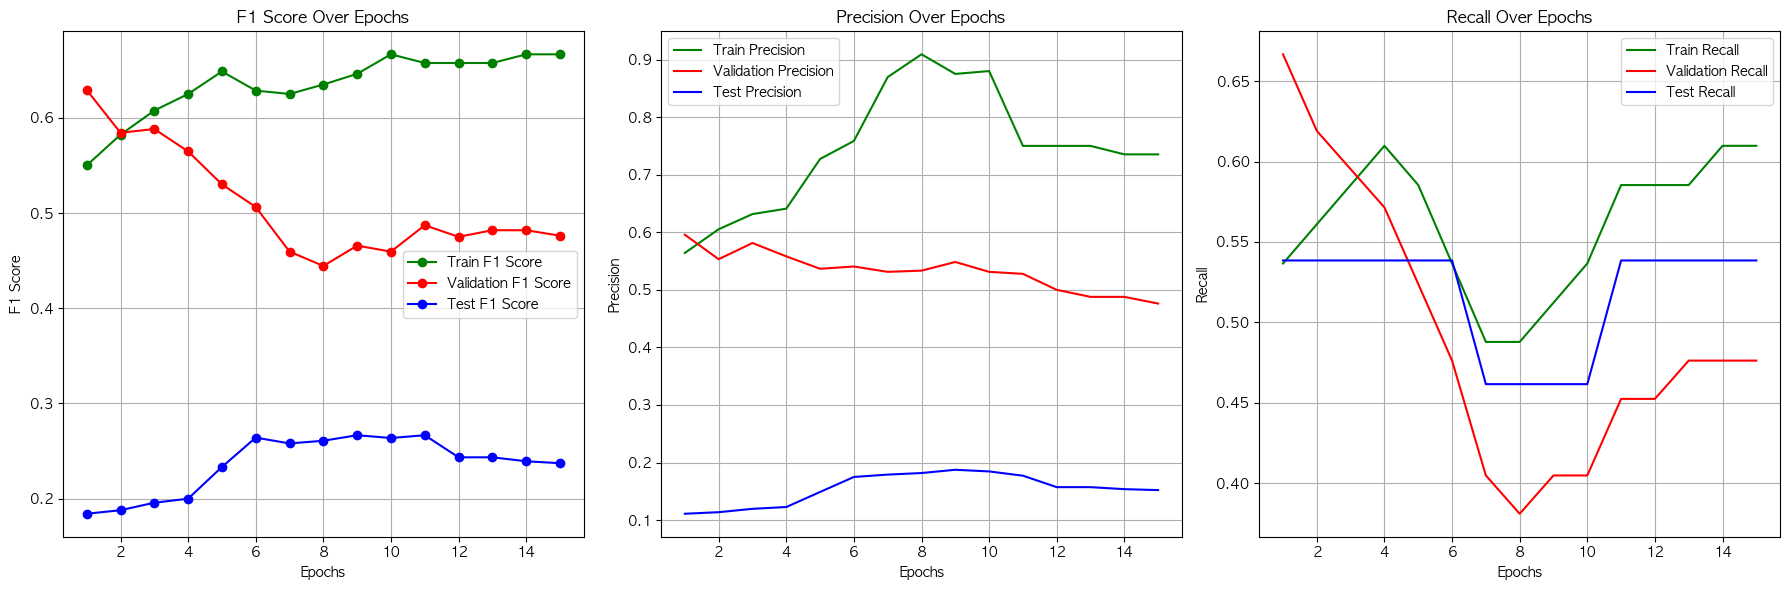

In [81]:
# 콜백 인스턴스 생성
f1_callback = F1ScoreCallback(X_train, y_train, X_val, y_val, X_test, y_test)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)


# 모델 학습
history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_data=(X_test, y_test),
    callbacks=[f1_callback, early_stopping, model_checkpoint_callback],
    verbose=2
)

# 학습 완료 후 지표 플로팅
f1_callback.plot_metrics()

In [82]:
final_model_path = '/Users/yangdong-yeong/Desktop/Fnguide/Check_Point/LSTM_100억~200억_2차'
model.save(final_model_path)
print(f"Model saved to {final_model_path}")

INFO:tensorflow:Assets written to: /Users/yangdong-yeong/Desktop/Fnguide/Check_Point/LSTM_100억~200억_2차/assets


INFO:tensorflow:Assets written to: /Users/yangdong-yeong/Desktop/Fnguide/Check_Point/LSTM_100억~200억_2차/assets


Model saved to /Users/yangdong-yeong/Desktop/Fnguide/Check_Point/LSTM_100억~200억_2차


In [83]:
# Check class distribution in the training set
unique, counts = np.unique(y_train, return_counts=True)
print("Train label distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(y_val, return_counts=True)
print("Validation label distribution:", dict(zip(unique, counts)))

unique, counts = np.unique(y_test, return_counts=True)
print("Test label distribution:", dict(zip(unique, counts)))

Train label distribution: {0: 41, 1: 41}
Validation label distribution: {0: 42, 1: 42}
Test label distribution: {0: 208, 1: 26}


# Test

## Data : 200억 ~ 300억

시가총액 200억~300억 데이터로 Model Test

## Load and Prepare the New Dataset

In [6]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import load_model
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

file_path = '/Users/yangdong-yeong/Desktop/Fnguide/data/kosdaq_200억~300억_scaled.csv'
ticker_df = pd.read_csv(file_path)

# '날짜' 열을 datetime 객체로 변환
ticker_df['날짜'] = pd.to_datetime(ticker_df['날짜'])

# ticker 별로 데이터 분할
tickers = ticker_df['ticker'].unique()
ticker_data = {ticker: ticker_df[ticker_df['ticker'] == ticker] for ticker in tickers}

# 기술적 지표 추가
for ticker in tickers:
    # Make a copy of the DataFrame to ensure it's not a view or slice
    data = ticker_data[ticker].copy(deep=True)
    
    # Compute and assign new columns
    data.loc[:, 'RSI'] = compute_RSI(data['종가'])
    macd, macd_signal = compute_MACD(data['종가'])
    data.loc[:, 'MACD'] = macd
    data.loc[:, 'MACD_Signal'] = macd_signal
    data.loc[:, 'Stochastic_Oscillator'] = compute_Stochastic_Oscillator(data)
    bollinger_up, bollinger_down = compute_Bollinger_Bands(data['종가'])
    data.loc[:, 'Bollinger_Up'] = bollinger_up
    data.loc[:, 'Bollinger_Down'] = bollinger_down
    data.loc[:, 'VWAP'] = compute_VWAP(data)
    
    sma_values = compute_SMA(data['종가'], [5, 20, 60, 120])
    for sma_key, sma_value in sma_values.items():
        data.loc[:, sma_key] = sma_value
    
    # Fill NaN values using the new recommended methods
    data.bfill(inplace=True)
    data.ffill(inplace=True)
    
    # Assign the modified DataFrame back to the dictionary
    ticker_data[ticker] = data

# Feature columns remain the same as you trained your model with these features
feature_columns = [
    '시가', '고가', '저가', '종가', '거래량', 
    'RSI', 'MACD', 'MACD_Signal', 
    'Stochastic_Oscillator', 'Bollinger_Up', 'Bollinger_Down', 
    'VWAP', 'SMA_5', 'SMA_20', 'SMA_60', 'SMA_120'
]

# Create sequences for the new dataset
sequence_length = 120
look_forward = 20

new_sequences = []
new_labels = []

for ticker in tickers:
    df = ticker_data[ticker]
    if len(df) >= sequence_length + look_forward:  # Ensure there's enough data
        seqs, labs = create_sequences_and_labels(df, sequence_length, look_forward=look_forward)
        new_sequences.append(seqs)
        new_labels.append(labs)

if new_sequences:
    new_sequences = np.concatenate(new_sequences)
    new_labels = np.concatenate(new_labels)
else:
    new_sequences, new_labels = np.array([]), np.array([])

print(f"New Sequences Shape: {new_sequences.shape if new_sequences.size > 0 else 'No sequences available'}")
print(f"New Labels Shape: {new_labels.shape if new_labels.size > 0 else 'No labels available'}")


ValueError: too many values to unpack (expected 2)

## Load the Trained Model and Predict

In [35]:
# Load the trained model - replace this path with the path to your saved model
model_path = '/Users/yangdong-yeong/Desktop/Fnguide/Check_Point/LSTM_100억~200억_2차.h5'
model = load_model(model_path)

# Predict on the new data
predictions = model.predict(new_sequences)
predicted_labels = (predictions > 0.5).astype(int)


83/83 [==============================] - 1s 8ms/step


## Evaluate the Model Performance

In [36]:
from sklearn.metrics import accuracy_score

# Actual labels are new_labels
actual_labels = new_labels

# Calculate performance metrics
accuracy = accuracy_score(actual_labels, predicted_labels)
precision = precision_score(actual_labels, predicted_labels, zero_division=0)
recall = recall_score(actual_labels, predicted_labels, zero_division=0)
f1 = f1_score(actual_labels, predicted_labels, zero_division=0)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")


Accuracy: 0.5919
Precision: 0.0833
Recall: 0.4560
F1 Score: 0.1408
